In [2]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
import scipy
import numpy as np
import string
import random
import string
from sklearn import linear_model
import csv
import os
import statistics as st
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# path = ""

out_path = "processed_endomondoHR_proper.npy"

data = np.load(out_path, allow_pickle= True)[0]

In [4]:
# creating some dictionaries for initial exploration
user_gender = defaultdict() # user and their gender
sport_fem = defaultdict()
sport_male = defaultdict()
sport_uk = defaultdict()
user_sport = defaultdict(list) # user and all the sports they play
user_sport_times = defaultdict(dict) # duration of a sport each time a user plays it
sport_times = defaultdict(list) # duration of each sport
user_sport_avghr = defaultdict(dict) # avg heartrate of a sport each time a user plays it
sport_avghr = defaultdict(list) # avghr of each user 
sport_list = []
sport_user = defaultdict(list)


In [5]:
data[0].keys()

dict_keys(['since_begin', 'since_last', 'tar_derived_speed', 'heart_rate', 'distance', 'sport', 'tar_heart_rate', 'derived_speed', 'id', 'timestamp', 'time_elapsed', 'altitude', 'gender', 'longitude', 'latitude', 'userId'])

In [6]:

# for d in data:
#     user_gender[d['userId']] = d['gender']
#     user_sport[d['userId']].append(d['sport'])
#     durtime = (d['timestamp'][-1] - d['timestamp'][0] ) / (3600) # duration in hours
#     #user_sport_times[d['userId']][d['sport']].append(durtime)
#     sport_times[d['sport']].append(durtime)
#     avgtarhr = np.mean(d['tar_heart_rate']) #avg tar hr
#     #user_sport_avghr[d['userId']][d['sport']].append(avgtarhr)
#     sport_avghr[d['sport']].append(avgtarhr)




In [7]:

for d in data:
    user_gender[d['userId']] = d['gender']

    if d['gender'] == 'female':
        if d['sport'] not in sport_fem.keys():
            sport_fem[d['sport']] = 0
        sport_fem[d['sport']] += 1
    
    elif d['gender'] == 'male':
        if d['sport'] not in sport_male.keys():
            sport_male[d['sport']] = 0
        sport_male[d['sport']] += 1

    else:
        if d['sport'] not in sport_uk.keys():
            sport_uk[d['sport']] = 0
        sport_uk[d['sport']] += 1


    if d['sport'] not in sport_list:
        sport_list.append(d['sport'])

    if d['sport'] not in user_sport[d['userId']]:
        user_sport[d['userId']].append(d['sport'])
    
    if d['userId'] not in sport_user[d['sport']]:
        sport_user[d['sport']].append(d['userId'])

    durtime = (d['timestamp'][-1] - d['timestamp'][0] ) / (3600) # duration in hours
    #user_sport_times[d['userId']][d['sport']].append(durtime)
    if d['userId'] not in user_sport_times.keys():
        user_sport_times[d['userId']] = {}
    if d['sport'] not in user_sport_times[d['userId']].keys():
        user_sport_times[d['userId']][d['sport']] = []
    user_sport_times[d['userId']][d['sport']].append(durtime)
    sport_times[d['sport']].append(durtime)
    
    avgtarhr = np.mean(d['tar_heart_rate']) #avg tar hr
    #user_sport_avghr[d['userId']][d['sport']].append(avgtarhr)
    if d['userId'] not in user_sport_avghr.keys():
        user_sport_avghr[d['userId']] = {}
    if d['sport'] not in user_sport_avghr[d['userId']].keys():
        user_sport_avghr[d['userId']][d['sport']] = []
    user_sport_avghr[d['userId']][d['sport']].append(avgtarhr)
    sport_avghr[d['sport']].append(avgtarhr)



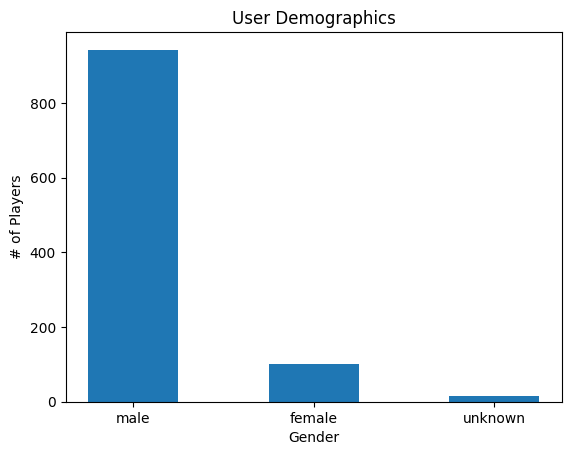

In [8]:
#some user demo graphics
m, f, u = 0, 0, 0
for k,v in user_gender.items():
    if v == 'male':
        m += 1
    elif v == 'female':
        f += 1
    else:
        u += 1

categories = ['male', 'female', 'unknown']
counts = [m, f, u]
plt.xlabel("Gender")
plt.ylabel("# of Players")
plt.title("User Demographics")
plt.bar(categories, counts, width=0.5)
plt.savefig('Demographics')

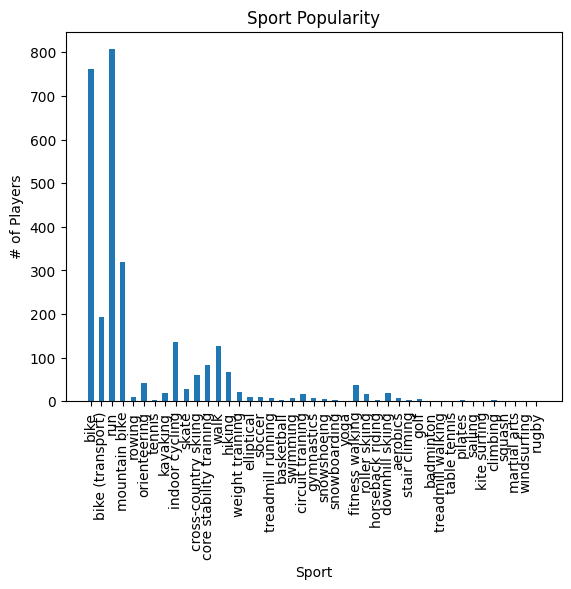

In [9]:
#sport popularity in total 
categories = sport_user.keys()
counts = [len(u) for u in sport_user.values()]
plt.xlabel("Sport")
plt.ylabel("# of Players")
plt.title("Sport Popularity")
plt.bar(categories, counts, width=0.5)
plt.xticks(rotation=90)
plt.savefig('Sport Popularity')

In [10]:
for sp in sport_list:
    if sp not in sport_male.keys():
        sport_male[sp] = 0

    if sp not in sport_fem.keys():
        sport_fem[sp] = 0
    
    if sp not in sport_uk.keys():
        sport_uk[sp] = 0


In [11]:
print(len(sport_male), len(sport_fem), len(sport_uk))

43 43 43


In [12]:
sorted_counts = defaultdict(list) #male,female, uk
for sp in sport_list:
    sorted_counts[sp].append(sport_male[sp]) #
    sorted_counts[sp].append(sport_fem[sp])
    sorted_counts[sp].append(sport_uk[sp])
    # sorted_counts[sp].append(np.ceil(sport_male[sp]*10000/68386)) #
    # sorted_counts[sp].append(np.ceil(sport_fem[sp]*1000 /5575))
    # sorted_counts[sp].append(np.ceil(sport_uk[sp]* 100 /608))
#sorted_counts


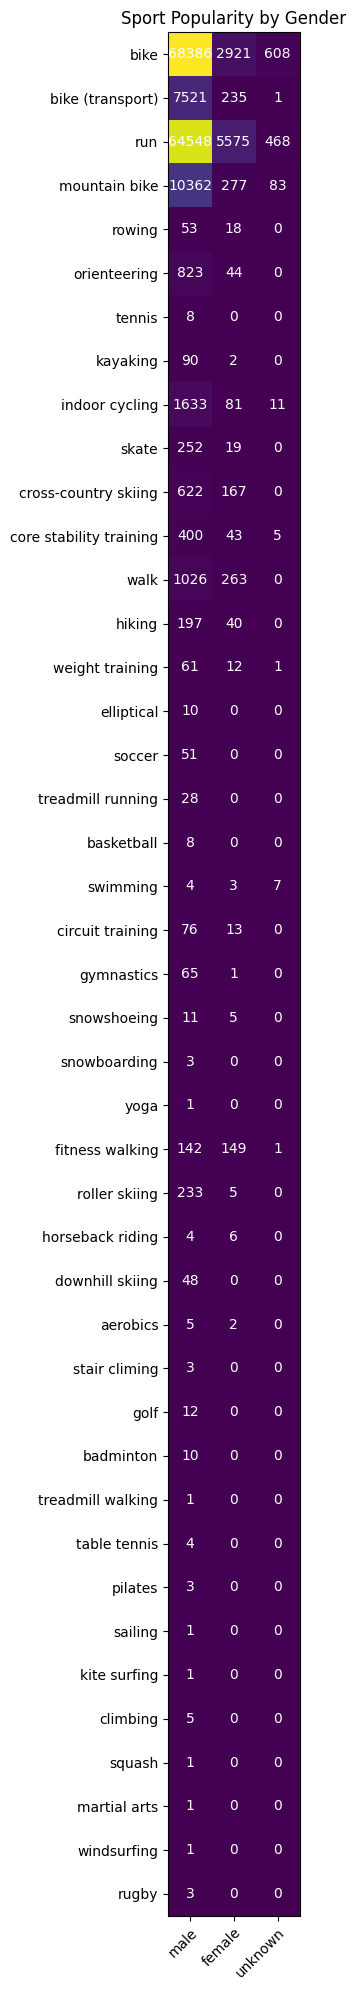

In [13]:
# sport-gender preference
#https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap
#https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
sports_vals = sorted_counts.keys()
gender_vals = ['male', 'female', 'unknown']
counts = np.array(list(sorted_counts.values()))

#print(counts)

fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(counts)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(gender_vals)), labels=gender_vals)
ax.set_yticks(np.arange(len(sports_vals)), labels=sports_vals)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(sports_vals)):
    for j in range(len(gender_vals)):
        text = ax.text(j, i, counts[i, j], ha="center", va="center", color="w")

ax.set_title("Sport Popularity by Gender")
fig.tight_layout()
# plt.show()
plt.savefig('sport-gender-fraction')

In [14]:
# # sport-gender preference--- sort of incorrect. user sorted couter to plot instead
# #https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/
# X = sport_fem.keys()
# fems = [v/max(sport_fem.values()) for v in sport_fem.values()] 
# male = [v/max(sport_male.values()) for v in sport_male.values()] 
# uk = [v/max(sport_uk.values()) for v in sport_uk.values()]

  
# X_axis = np.arange(len(X)) 
  
# plt.bar(X_axis - 0.4, fems, 0.3, label = 'Female') 
# plt.bar(X_axis , male, 0.3, label = 'Male') 
# plt.bar(X_axis + 0.4, uk, 0.3, label = 'Unknown') 
  
# plt.xticks(X_axis, X) 
# plt.xlabel("Sports") 
# plt.ylabel("# of Players") 
# plt.title("Fraction of Players Based on Gender That Played Each Sport") 
# plt.legend() 
# plt.xticks(rotation=90)
# # plt.show()
# plt.savefig('sport-gender-fraction') 

In [15]:
# print(fems)
# print(male)

In [16]:
# sport intersections
sport_intersections = {}

for s1 in sport_user:
    for s2 in sport_user:
        if s1 == s2:
            sport_intersections[(s1,s2)] = 0
            continue
        # if (s2,s1) in sport_intersections.keys():
        #     continue
        intersect = len(list(set(s1).intersection(s2)))
        sport_intersections[(s1,s2)] = intersect
    

# sport_intersections


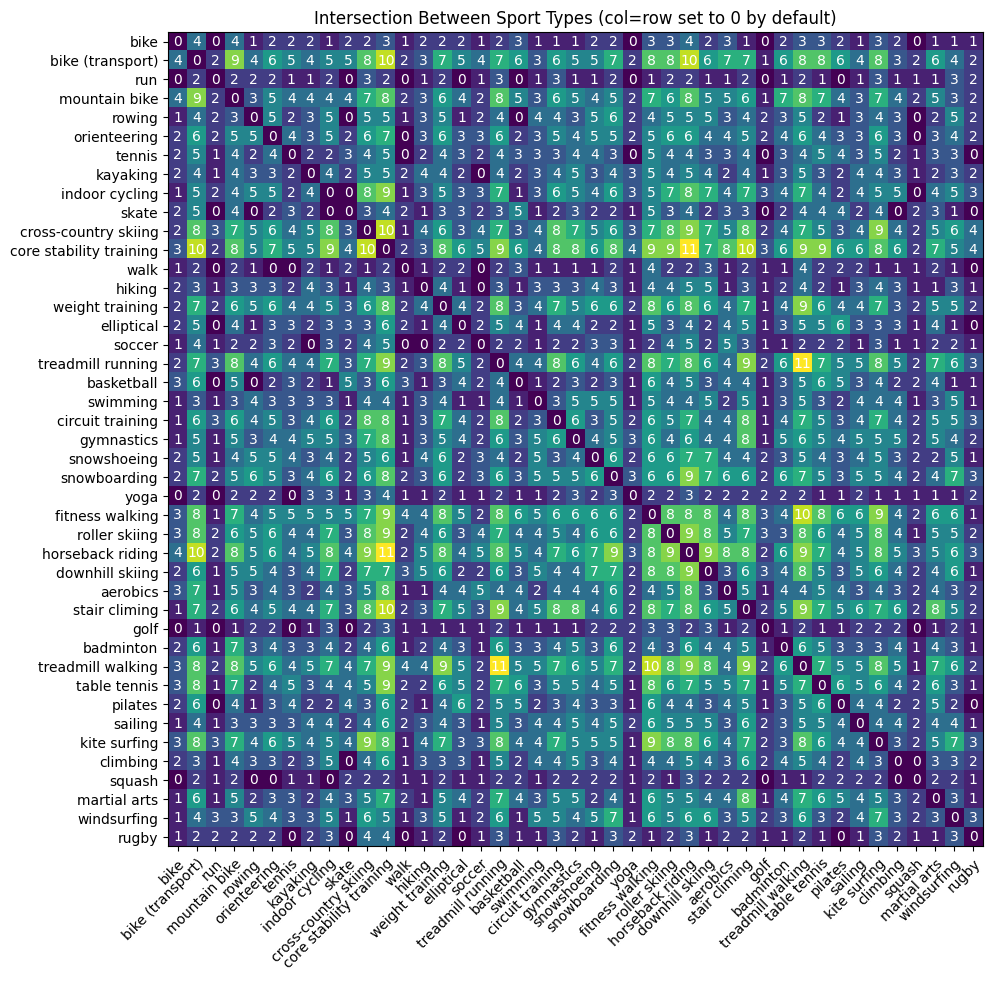

In [17]:
#plotting intersections
sports_vals = sport_list
sports_vals_2 = sport_list
sp_sp = []

for sp in sports_vals:
    sp_int = []
    for sp2 in sports_vals_2:
        sp_int.append(sport_intersections[(sp,sp2)])
    sp_sp.append(sp_int)

sp_sp = np.array(sp_sp)
# print(sp_sp)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(sp_sp)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(sports_vals_2)), labels=sports_vals_2)
ax.set_yticks(np.arange(len(sports_vals)), labels=sports_vals)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(sports_vals)):
    for j in range(len(sports_vals_2)):
        text = ax.text(j, i, sp_sp[i, j], ha="center", va="center", color="w")

ax.set_title("Intersection Between Sport Types (col=row set to 0 by default)")
fig.tight_layout()
#plt.show()
plt.savefig('sport-sport')

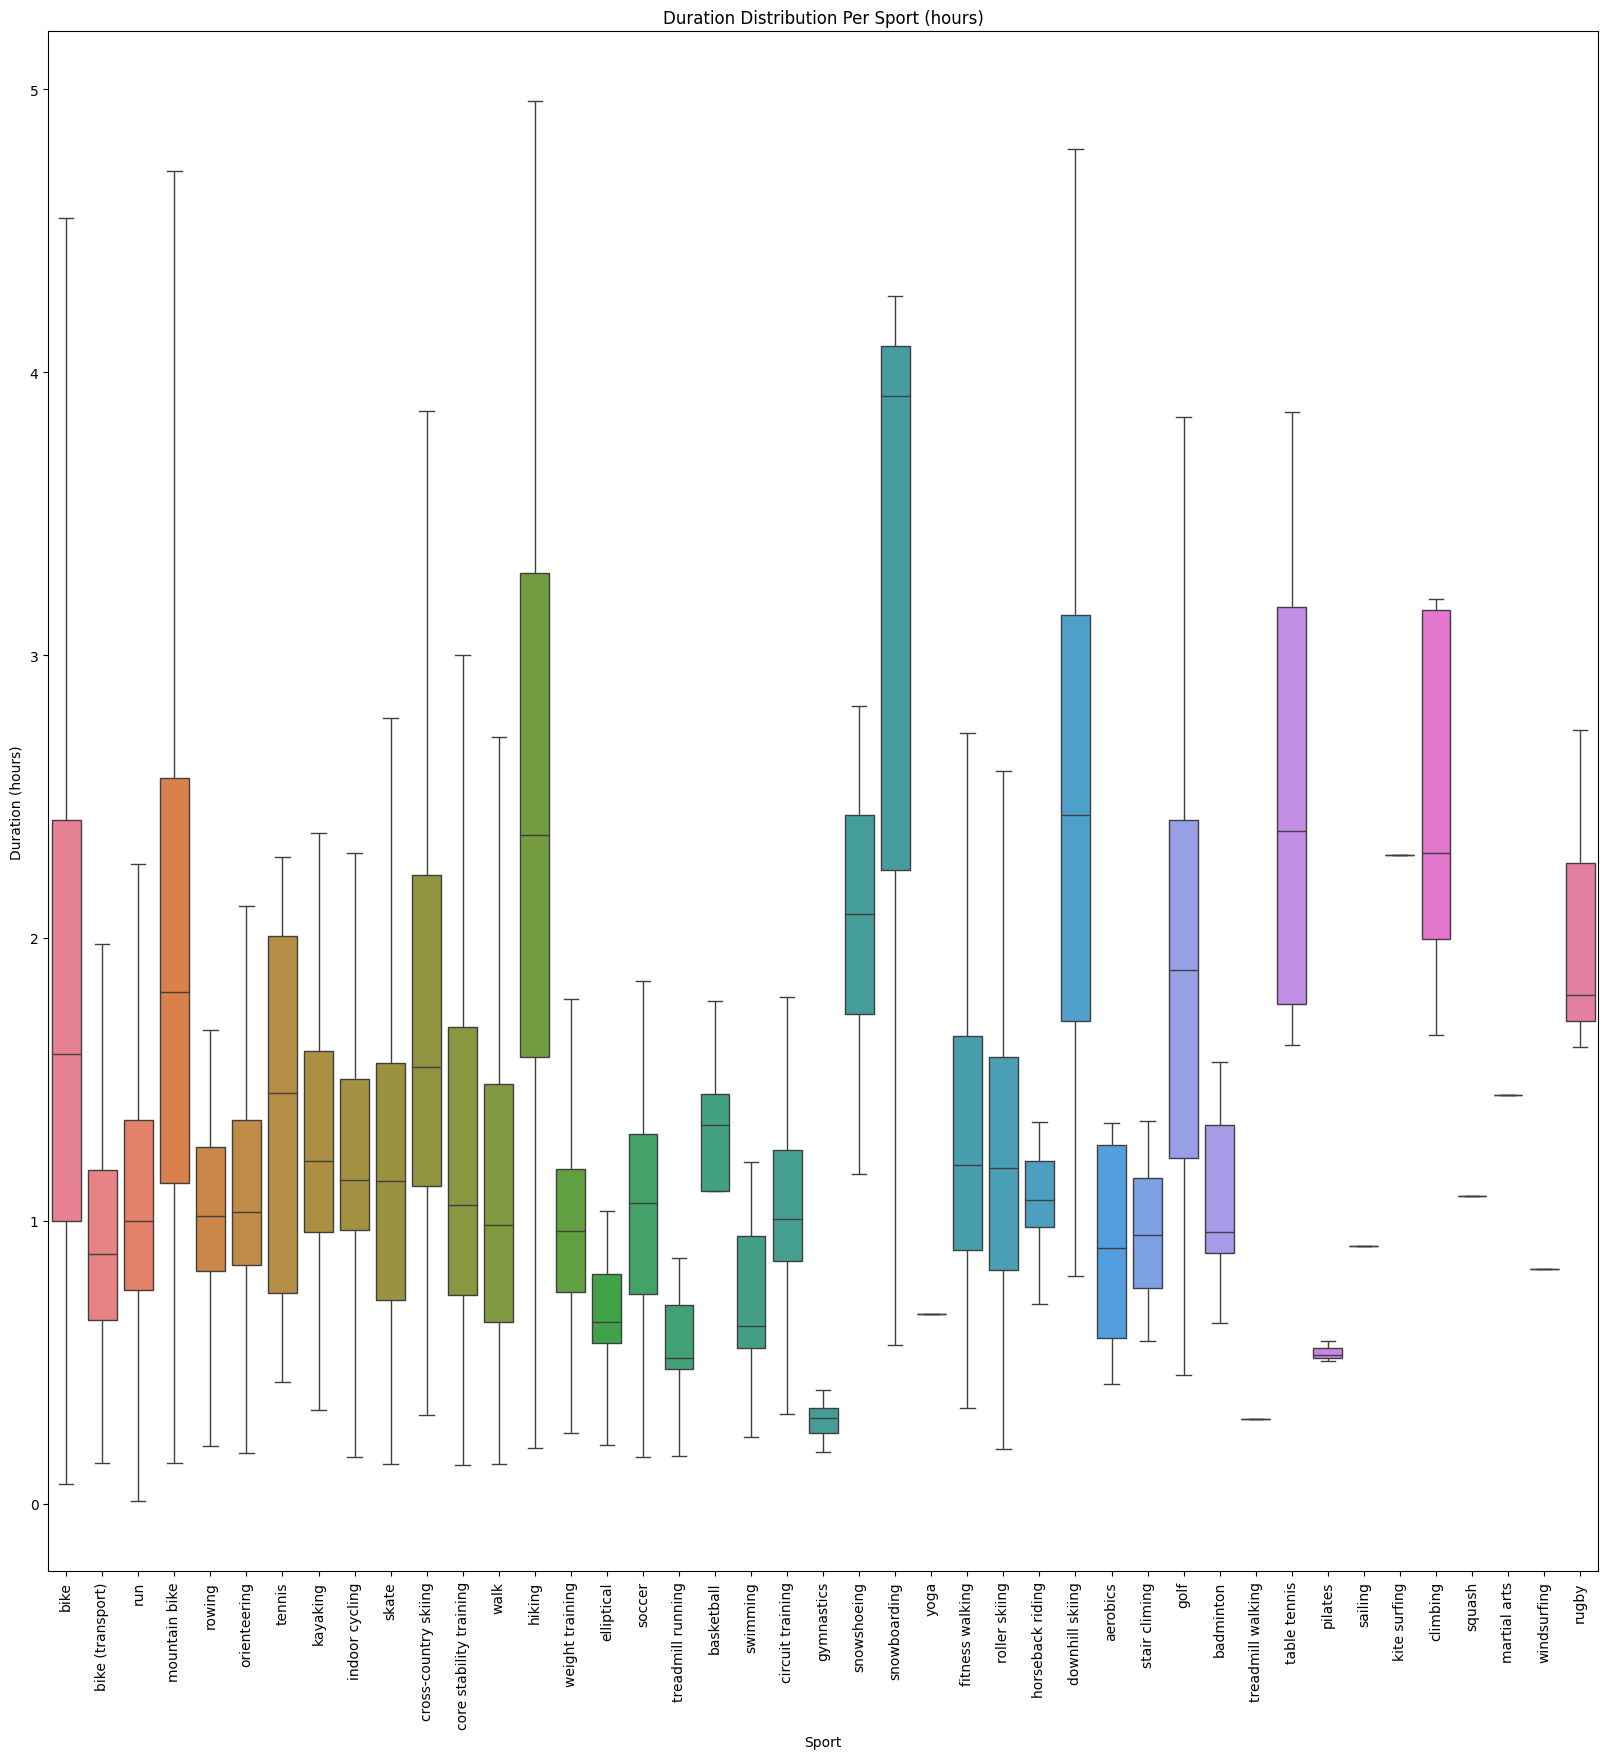

In [33]:
#sport and time duration relationships
# sport_times
#https://stackoverflow.com/questions/37576160/how-do-i-add-category-names-to-my-seaborn-boxplot-when-my-data-is-from-a-python
plt.figure(figsize=(20, 20))
bw = sns.boxplot(data=sport_times, showfliers=False)
bw.set(title='Duration Distribution Per Sport (hours)', xlabel= 'Sport', ylabel= 'Duration (hours)')
bw.tick_params(axis='x', labelrotation= 90)
plt.savefig('Duration Distribution Per Sport (hours)')

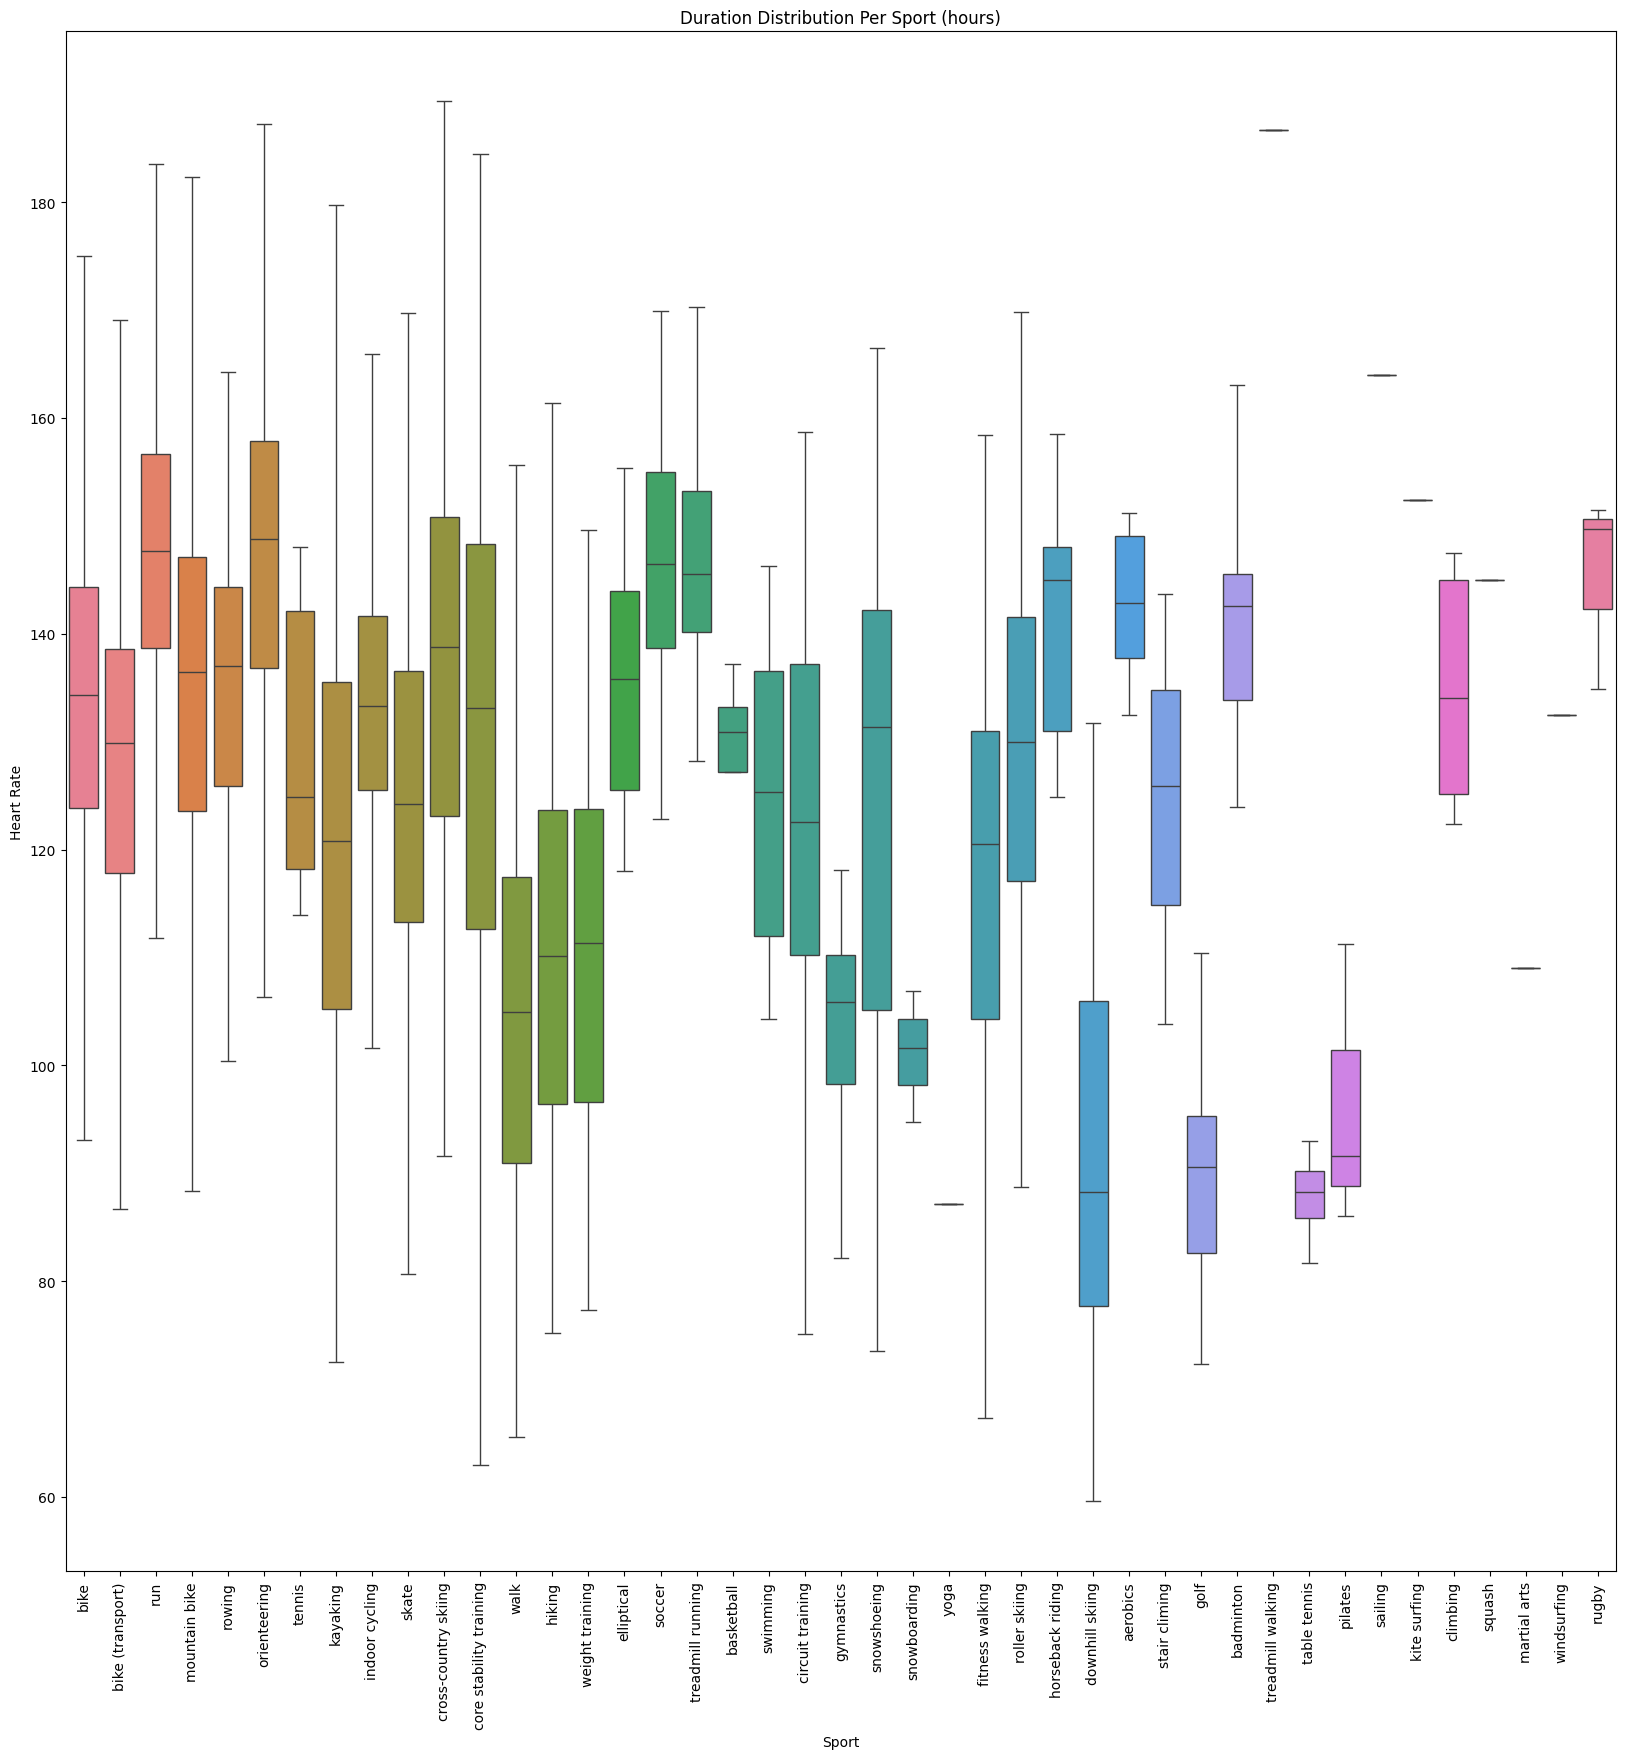

In [34]:
#sport and heart rate relationship
plt.figure(figsize=(20, 20))
bw = sns.boxplot(data=sport_avghr, showfliers=False)
bw.set(title='Duration Distribution Per Sport (hours)', xlabel= 'Sport', ylabel= 'Heart Rate')
bw.tick_params(axis='x', labelrotation= 90)
plt.savefig('Heart Rate Distribution Per Sport (hours)')

In [19]:
#https://stackoverflow.com/questions/43971138/python-plotting-colored-grid-based-on-values

#recommend low impact exercises that can last for the same duration ( easy day ), may need to consider other factors like speeds
#recommend high impact exercises that can achieve results in smaller time frame (busy day), may need to consider other factors like speeds
#recommend exercises user is likely to enjoy ( jaccard similarity)
#recommend routes user is likely to enjoy (slightly tougher)
#

#plot players per sport
#plot avg durations per sport
#plot average heart rate per sport
#plot sport popularity across gender
